# Gaussian Process Regression for atmospheric CO2 prediction

Following a great lecture by Professor Anna Scaife I decided to reproduce her figures. Source: https://youtu.be/UpsV1y6wMQ8

Data set used for this exercise is taken from NASA database: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

In [1]:
import numpy as np
import pandas as pd
import george
import urllib.request
import os
import shutil
from matplotlib import pyplot as plt
import numpy as np

# Upload data set:
# url = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt'
# urllib.request.urlretrieve(url, 'co2_mm_mlo.txt')

# Pre-process the data set:
time = []
co2_seasonal = []
co2_trend = []

file = open("co2_mm_mlo.txt", "r")
fileLines = file.readlines()

for line in fileLines:

    # Get destination names:
    if line[0] != '#':
        line = line.replace(" ", ',').replace('\n', '').split(',')
        line = list(filter(None, line)) # fastest
        time.append(float(line[2]))
        co2_seasonal.append(float(line[4]))
        co2_trend.append(float(line[5]))

file.close()

pd.DataFrame(co2_trend).head(5)

,0
0,314.62
1,315.29
2,314.71
3,314.85
4,314.98


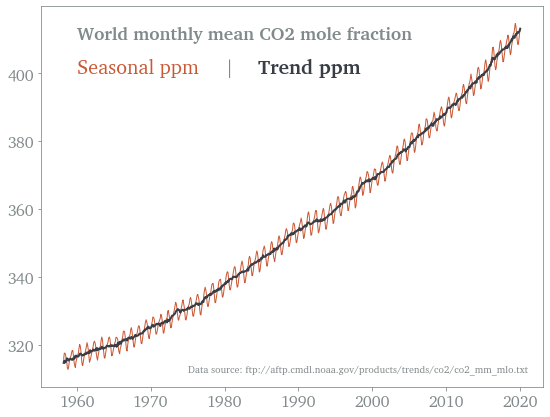

In [2]:
# Plot the data set:
csfont = {'fontname':'Charter', 'fontweight':'regular'}
hfont = {'fontname':'Charter', 'fontweight':'bold'}
ifont = {'fontname':'Charter', 'fontweight':'regular', 'style':'italic'}
seasonalColour = '#ca5834'
trendColour = '#393e46'
textColour = '#818a8b'
font_axes = 16
font_labels = 22
font_title = 18
font_text = 20

# Plot graph:
figure = plt.figure(figsize=(9, 7))
figureSubplot = figure.add_subplot(1,1,1)
plt.plot(time, co2_seasonal, color=seasonalColour, linestyle='-', linewidth=1.0, zorder=1)
plt.plot(time, co2_trend, color=trendColour, linestyle='-', linewidth=2.0)

plt.text(1960, 410, 'World monthly mean CO2 mole fraction', **hfont, fontsize=font_title, color=textColour, horizontalalignment='left')
plt.text(1960, 400, 'Seasonal ppm', **csfont, fontsize=font_text, color=seasonalColour, horizontalalignment='left')
plt.text(1980, 400, '|', **csfont, fontsize=font_title, color=textColour, horizontalalignment='left')
plt.text(1984.5, 400, 'Trend ppm', **hfont, fontsize=font_text, color=trendColour, horizontalalignment='left')
plt.text(1975, 312, 'Data source: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt', **csfont, fontsize=10, color=textColour, horizontalalignment='left')

figureSubplot.spines['bottom'].set_color(textColour)
figureSubplot.spines['top'].set_color(textColour)
figureSubplot.spines['left'].set_color(textColour)
figureSubplot.spines['right'].set_color(textColour)
figureSubplot.tick_params(axis='x', colors=textColour)
figureSubplot.tick_params(axis='y', colors=textColour)

# Set the tick labels font
for label in (figureSubplot.get_xticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(font_axes)

for label in (figureSubplot.get_yticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(font_axes)

## Building the GPR pieces

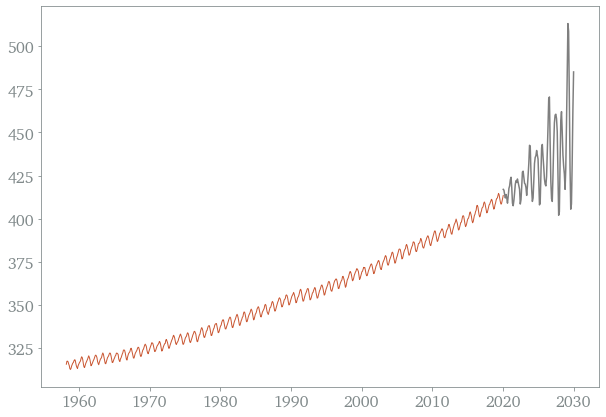

In [3]:
# GP Kernel:

# Long-trend variation:
k1 = 50 * george.kernels.ExpSquaredKernel(100.0**2)

# Decaying periodic kernel for seasonal variation:
k2 = 2.4**2 * george.kernels.ExpSquaredKernel(90**2) * george.kernels.ExpSine2Kernel(2.0 / 1.3**2, 1.0)

# Medium-term irregularities:
# k3 = 0.66**2 * george.kernels.RationalQuadraticKernel(0.78, 1.2**2)

# Noise:
# k4 = 0.18**2 * george.kernels.ExpSquaredKernel(1.6**2) + george.kernels.WhiteKernel(0.19)

kernel = k1 + k2

gp = george.GP(kernel, 0)
gp.compute(time)

x = np.linspace(max(time), 2030, 100)

mu, cov = gp.predict(co2_seasonal, x)
std = np.sqrt(np.diag(cov))

figure = plt.figure(figsize=(10, 7))
figureSubplot = figure.add_subplot(1,1,1)
plt.plot(time, co2_seasonal, color=seasonalColour, linestyle='-', linewidth=1.0, zorder=1)
# pred, pred_var = gp.predict(co2_seasonal, x_pred, return_var=True)
# plt.fill_between(x, mu - np.sqrt(cov), pred + np.sqrt(cov), color="k", alpha=0.2)
plt.plot(x, mu, "k", lw=1.5, alpha=0.5)

figureSubplot.spines['bottom'].set_color(textColour)
figureSubplot.spines['top'].set_color(textColour)
figureSubplot.spines['left'].set_color(textColour)
figureSubplot.spines['right'].set_color(textColour)
figureSubplot.tick_params(axis='x', colors=textColour)
figureSubplot.tick_params(axis='y', colors=textColour)

# Set the tick labels font
for label in (figureSubplot.get_xticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(font_axes)

for label in (figureSubplot.get_yticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(font_axes)